In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "plantvillage",
    shuffle=True,
    image_size= (IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names 
class_names


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [45]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 0 1 2 0 0 1 0 2 1 1 1 0 0 1 1 0 1 2 1 1 1 0 0 0 1 1 0 0 1 0]


2025-01-11 08:18:03.123700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
classname = dataset.class_names

2025-01-11 07:39:53.628525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


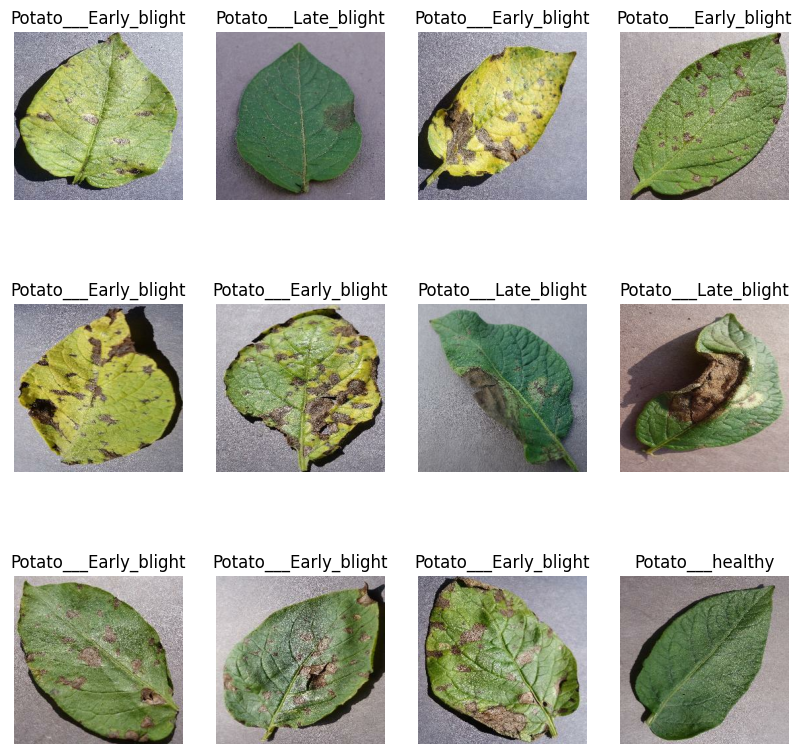

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classname[label_batch[i]])
        plt.axis("off")
        

In [9]:
train_size = 0.8
len(dataset)*train_size #32 * 0.8 = 24 batches


54.400000000000006

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)


14

In [12]:
val_size = 0.1
len(dataset) * val_size #100 * 0.1 = 10batches

6.800000000000001

In [13]:

val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)


8

In [15]:
train_split=0.8
val_split=0.1
test_split=0.1

assert train_split + val_split + test_split == 1  #0.8 + 0.1 + 0.1 = 1

In [16]:
#80% for training, 10% for validation, and 10% for testing
def get_dataset_paratitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert train_split + val_split + test_split == 1
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [17]:
train_ds, val_ds, test_ds = get_dataset_paratitions_tf(dataset)


In [18]:
len(train_ds)

54

In [19]:
len(val_ds)

6

In [20]:
len(test_ds)


8

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0 / 255)
])



In [23]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])


In [24]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),
        layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Flatten(), 
    
    layers.Dense(64, activation='relu'),
    
    layers.Dense(n_classes, activation='softmax'),
    
])

model.build(input_shape=input_shape)


In [26]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(
    optimizer = 'adam', 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
    metrics = ['accuracy'])

In [28]:
history = model.fit(
    train_ds,
    epochs = 10, 
    batch_size = BATCH_SIZE, 
    verbose = 1,
    validation_data = val_ds
)


Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 607ms/step - accuracy: 0.4215 - loss: 0.9636 - val_accuracy: 0.4375 - val_loss: 0.8910
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 546ms/step - accuracy: 0.5842 - loss: 0.8050 - val_accuracy: 0.7135 - val_loss: 0.5935
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 545ms/step - accuracy: 0.8031 - loss: 0.4632 - val_accuracy: 0.8594 - val_loss: 0.3989
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 621ms/step - accuracy: 0.8613 - loss: 0.3339 - val_accuracy: 0.8802 - val_loss: 0.2816
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 678ms/step - accuracy: 0.8621 - loss: 0.3293 - val_accuracy: 0.8594 - val_loss: 0.2496
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 752ms/step - accuracy: 0.9120 - loss: 0.2523 - val_accuracy: 0.8229 - val_loss: 0.5173
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 843ms/step - accuracy: 0.8885 - loss: 0.2679 - val_accuracy: 0.9115 - val_loss: 0.1730
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 665ms/step - accuracy: 0.9352 - loss: 0.1599 - val_accu

In [29]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.8816 - loss: 0.2867


In [30]:
scores

[0.2967516779899597, 0.890625]

In [31]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [32]:

history.history.keys()


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [33]:


print(history.history.keys()) 

# Check the type of the 'loss' metric
print(type(history.history['loss']))  # Should output: <class 'list'>

# Check the length of the 'loss' list (corresponds to the number of epochs)
print(len(history.history['loss'])) 



dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
<class 'list'>
10


In [34]:
acc = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [35]:
val_acc

[0.4375,
 0.7135416865348816,
 0.859375,
 0.8802083134651184,
 0.859375,
 0.8229166865348816,
 0.9114583134651184,
 0.9583333134651184,
 0.9635416865348816,
 0.875]

Text(0.5, 1.0, 'Training & Validation Loss')

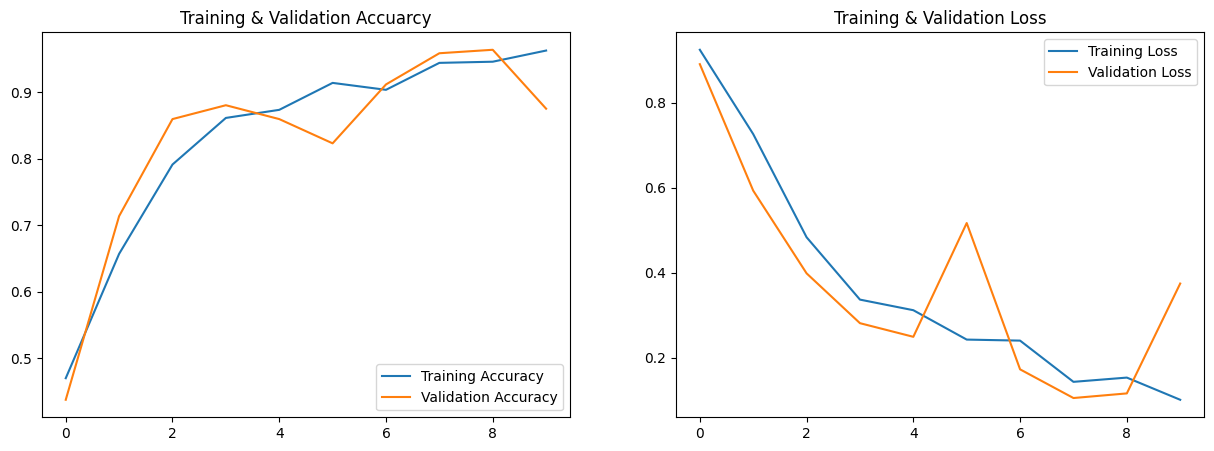

In [46]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(range(10), acc, label = "Training Accuracy")
plt.plot(range(10), val_acc, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title('Training & Validation Accuarcy')

plt.subplot(1, 2, 2)
plt.plot(range(10), loss, label = "Training Loss")
plt.plot(range(10), val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title('Training & Validation Loss')

first image to predict
actual label: Potato___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
predicted label: Potato___healthy


2025-01-11 10:02:00.601939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


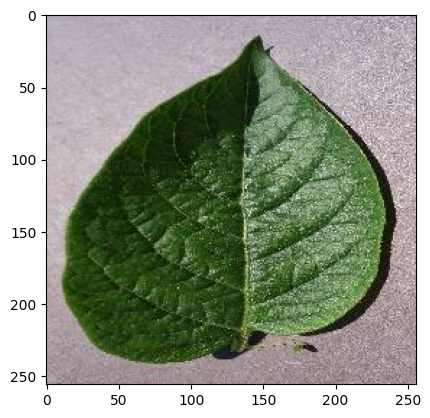

In [47]:
import numpy as np
for image_batch , labels_batch in test_ds.take(1):
    first_img = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_img)
    print('actual label:', classname[first_label])
    
    batch_prediction = model.predict(image_batch)
    print('predicted label:', classname[np.argmax(batch_prediction[0])])

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    prediction = model.predict(img_array)
    
    predicted_class = classname[np.argmax(prediction[0])]
    confidence = round(100 * (np.argmax(prediction[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2025-01-11 07:45:49.696336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


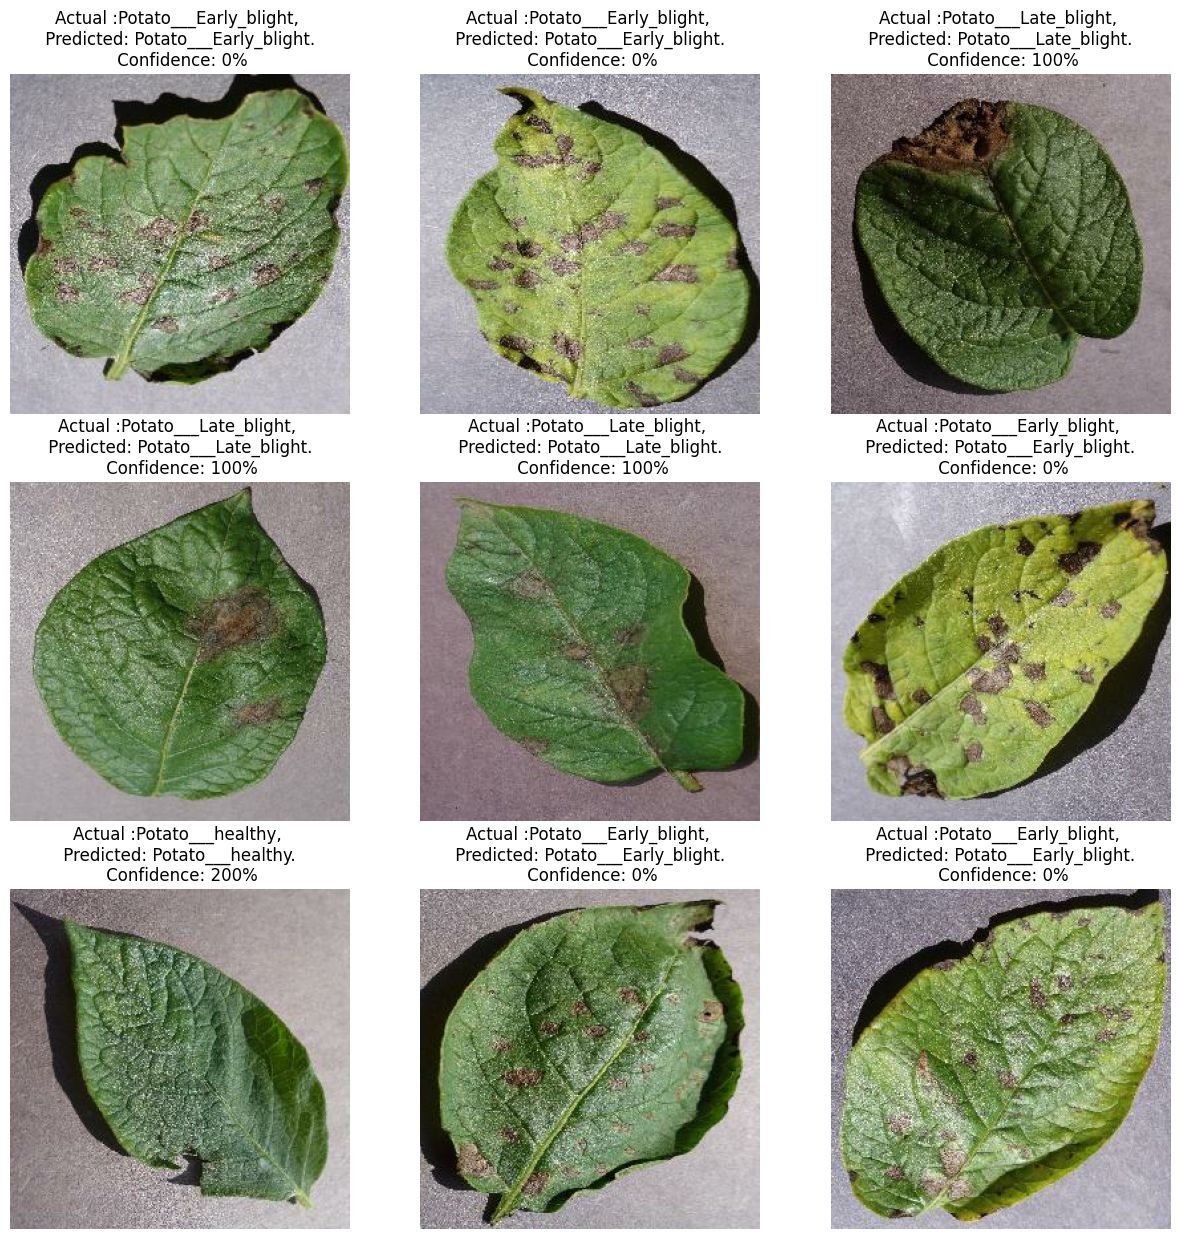

In [39]:
plt.figure(figsize = (15,15))

for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3 ,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i])
        actual_class = classname[labels[i]]
        
        plt.title(f"Actual :{actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}%")
        
        plt.axis("off")


In [40]:
import os

In [41]:
model_version = 1
model.save(f"../models/model_version_{model_version}.keras")  # Recommended


In [42]:
model_version = 2
model.save(f"../models/model_version_{model_version}.keras")  # Recommended
